In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import pathlib
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import os
import shutil
import numpy as np
import glob
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers
from tensorflow.keras.layers import Input, Add,Dropout, Dense, Activation, ZeroPadding2D, \
BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import  plot_model
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from datetime import datetime

from IPython.display import SVG
import scipy.misc
from matplotlib.pyplot import imshow
%matplotlib inline

In [17]:

!git clone https://github.com/I-m-Parthian/Monument-Recognition.git

fatal: destination path 'Monument-Recognition' already exists and is not an empty directory.


In [18]:
from PIL import Image
import os
dataset_dir = '/content/Monument-Recognition/Dataset'
img_size = None
num_classes = 0
for class_dir in os.listdir(dataset_dir):
    if os.path.isdir(os.path.join(dataset_dir, class_dir)):
        num_classes += 1
        for img_file in os.listdir(os.path.join(dataset_dir, class_dir)):
            if img_file.endswith('.jpg'):
                img_path = os.path.join(dataset_dir, class_dir, img_file)
                with Image.open(img_path) as img:
                    if img_size is None:
                        img_size = img.size
                    elif img_size != img.size:
                        print('Error: Images have different sizes')
                        break
print('Image size:', img_size)
print('Number of classes:', num_classes)

Image size: (64, 64)
Number of classes: 3


In [19]:
train_data_dir = '/content/Monument-Recognition/Dataset/1.Train'
#val_data_dir = 'x/val'
test_data_dir = '/content/Monument-Recognition/Dataset/Test'
img_size = (224, 224)
batch_size = 32

In [20]:
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
# val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [16]:
train_generator = train_datagen.flow_from_directory(train_data_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical',seed=42)
# val_generator = val_datagen.flow_from_directory(val_data_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical')
test_generator = test_datagen.flow_from_directory(test_data_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical')

Found 1925 images belonging to 49 classes.
Found 623 images belonging to 49 classes.


In [21]:
img_height = 224
img_width = 224

In [22]:
from tensorflow.keras.applications import VGG16,ResNet101,ResNet101V2, InceptionResNetV2,NASNetLarge,Xception

In [35]:
base_model = ResNet101V2(weights='imagenet',input_shape=(224,224,3),include_top=False,pooling='avg')
#base_model = Xception(weights='imagenet',input_shape=(224,224,3),include_top=False,pooling='avg')
#base_model = NASNetLarge(weights='imagenet',input_shape=(224,224,3),include_top=False,pooling='avg')
#base_model = InceptionResNetV2(weights='imagenet',input_shape=(224,224,3),include_top=False,pooling='avg')

# This is a try to train not just the last but last 3 layers of the network, this has to be done very carefully at a very low learning rate
for layer in base_model.layers[:-3]:
    layer.trainable = False
for layer in base_model.layers[-3:]:
    layer.trainable = True
model = Sequential([
  base_model, # Pretrained model
  # Last layers that we add manually
  Dense(1024, activation='relu'),
  # Dropout imporves generalisation
  Dropout(0.3),
  Dense(512,activation = 'relu'),
  Dropout(0.3),
  Dense(256, activation='relu'),
  Dropout(0.3),
  Dense(128, activation = 'relu'),
  Dense(49, activation='softmax'),
])
# RMSprop worked the best for this model

In [36]:
optimizer = keras.optimizers.RMSprop(learning_rate=0.0008)
model.compile(optimizer=optimizer,loss ="categorical_crossentropy", metrics=["accuracy"])

In [38]:
history = model.fit(train_generator,epochs=25,
                    #validation_data=valid_datagen, validation_steps=20,
                    steps_per_epoch=32,validation_data=train_generator)
# history = model.fit_generator(train_generator, epochs=10, validation_data=train_generator)


Epoch 1/25
32/32 [==============================] - 244s 8s/step - loss: 3.6998 - accuracy: 0.1143 - val_loss: 3.0847 - val_accuracy: 0.2639
Epoch 2/25
32/32 [==============================] - 228s 7s/step - loss: 3.0531 - accuracy: 0.2705 - val_loss: 2.2736 - val_accuracy: 0.4348
Epoch 3/25
32/32 [==============================] - 281s 9s/step - loss: 2.4435 - accuracy: 0.3671 - val_loss: 1.8647 - val_accuracy: 0.5117
Epoch 4/25
32/32 [==============================] - 229s 7s/step - loss: 2.0781 - accuracy: 0.4678 - val_loss: 1.3818 - val_accuracy: 0.6421
Epoch 5/25
32/32 [==============================] - 229s 7s/step - loss: 1.7822 - accuracy: 0.5303 - val_loss: 1.2673 - val_accuracy: 0.6706
Epoch 6/25
32/32 [==============================] - 281s 9s/step - loss: 1.6537 - accuracy: 0.5707 - val_loss: 1.0407 - val_accuracy: 0.7143
Epoch 7/25
32/32 [==============================] - 280s 9s/step - loss: 1.4672 - accuracy: 0.5998 - val_loss: 1.1476 - val_accuracy: 0.6857
Epoch 8/25
32

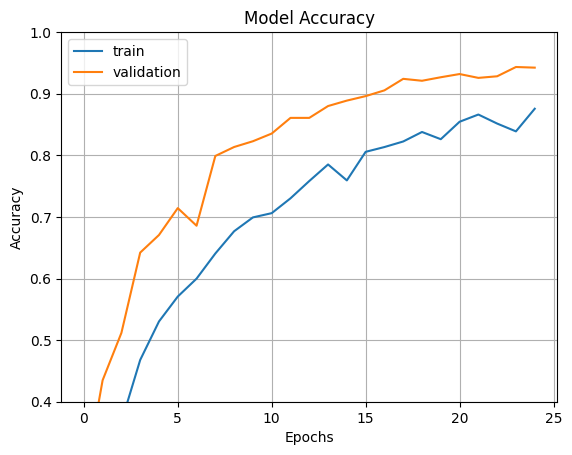

In [43]:
# Evaluate the ResNet-50 model
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4, ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()



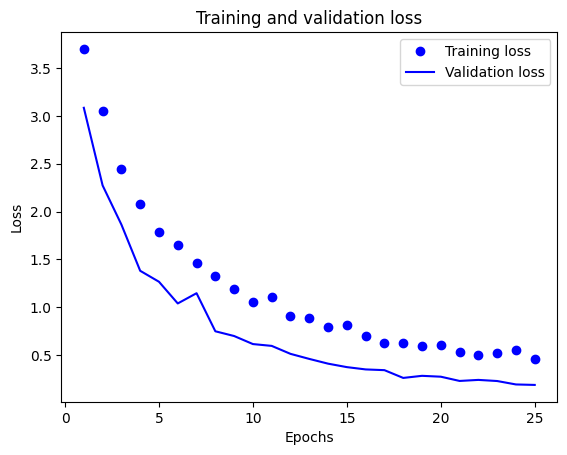

In [44]:
import matplotlib.pyplot as plt
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [48]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
image = load_img('/content/Monument-Recognition/Dataset/1.Train/Fatehpur Sikri Fort/7689ipok,.jpg', target_size=(224, 224))
img = img_to_array(image)
img = img.reshape((1,) + img.shape)
img /= 255.

In [49]:
prediction = model.predict(img)

1/1 [==============================] - 3s 3s/step


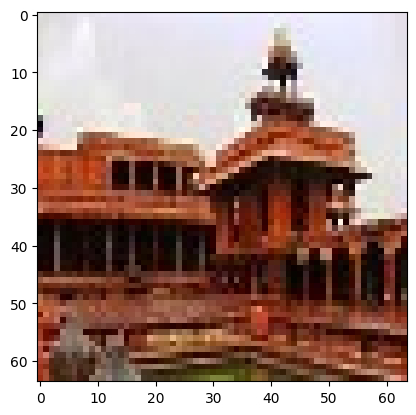

Fatehpur Sikri Fort


In [50]:
class_indices = train_generator.class_indices
inv_class_indices = {v: k for k, v in class_indices.items()}
monument_name = inv_class_indices[np.argmax(prediction)]
from skimage import io
img = io.imread('/content/Monument-Recognition/Dataset/1.Train/Fatehpur Sikri Fort/7689ipok,.jpg')
plt.imshow(img)
plt.show()
print(monument_name)